In [1]:
%matplotlib inline
import sys, gc
sys.path.append('/home/igr/src/model/nengo_maze_env')
from functools import partial
import nengo
import numpy as np
import matplotlib.pyplot as plt
from prf_net import PRF
from cdisp import CDISP
from hsp import HSP
from isp import ISP
from tqdm import tqdm
import scipy.interpolate
from scipy.interpolate import Rbf, PchipInterpolator, Akima1DInterpolator
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance, sample_by_activity)
from nengo_extras.neurons import (
    rates_kernel, rates_isi, spikes2events )

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module '_yaml' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def distance_probs(dist, sigma):                                                                                                   
    weights = np.exp(-dist/sigma**2)                                                                                               
    prob = weights / weights.sum(axis=0)                                                                                           
    return prob                                                                                                                    


In [3]:
def contiguous_ranges(input, return_indices=False):
    """Finds contiguous regions of the array "input". Returns
    a list of ranges with the start and end index of each region. Code based on:
    https://stackoverflow.com/questions/4494404/find-large-number-of-consecutive-values-fulfilling-condition-in-a-numpy-array/4495197
    """

    # Find the indices of changes in "condition"
    d = np.diff(input)
    nz, = d.nonzero() 

    print(nz)
    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the ranges by 1 to the right.
    nz += 1
    nz = np.concatenate([nz, [input.size]])
    
    ranges = np.vstack([ [nz[ri], nz[ri+1]] for ri in range(nz.size-1) ])
    ranges = np.vstack([[0, nz[0]], ranges])

    # Reshape the result into two columns
    ranges.shape = (-1,2)

    if return_indices:
        result = ( np.arange(*r) for r in ranges )
    else:
        result = ranges

    return result

In [4]:
dof_input_matrix = np.asarray(np.load("dof_array.npy"), dtype=np.float32)
print(dof_input_matrix.shape)
cnt_input_matrix = np.asarray(np.load("cnt_array.npy"), dtype=np.float32)
print(cnt_input_matrix.shape)

(4096, 1771)
(4096, 1771)


In [5]:
n_steps = 100
n_trials = 3
input_matrix = np.vstack((dof_input_matrix, cnt_input_matrix))
normed_input_matrix = input_matrix / np.max(input_matrix)
train_data = np.tile(np.repeat(normed_input_matrix[:,:10], n_steps, axis=1), (1, n_trials))
print(train_data.shape)
print(np.max(train_data))
np.save("srf_nengo_dof_input_matrix.npy", train_data)

(8192, 3000)
0.764977


In [6]:
def array_input(input_matrix, dt, t, *args):
    i = int(t/dt)
    if i >= input_matrix.shape[1]:
        i = -1
    return input_matrix[:,i]

In [264]:
N_inputs = train_data.shape[0]

N_outputs_srf = 1000
N_exc_srf = N_inputs
N_inh_srf = int(N_outputs_srf/4)


N_inh_decoder = int(N_inh_srf)

dt = 0.001
srf_seed = 19
t_end = train_data.shape[1] * dt
print(f't_end = {t_end}')


srf_place_network = nengo.Network(label="Learning with spatial receptive fields", seed=srf_seed)
rng = np.random.RandomState(seed=srf_seed)



params = {'w_initial_E': 0.0817, 
          'w_initial_EI': 0.00146, 
          'w_initial_I': -0.0355, 
          'w_EI_Ext': 0.0058, 
          'w_PV_E': 0.015, 
          'w_PV_I': 0.044, 
          'p_E_srf': 0.02, 
          'p_EE': 0.01, 
          'p_EI': 0.1,
          'p_EI_Ext': 0.007, 
          'p_PV': 0.01, 
          'tau_E': 0.005, 
          'tau_I': 0.020, 
          'learning_rate_I': 0.01, 
          'learning_rate_E': 0.05}

params = {'w_initial_E': 0.01, 
          'w_initial_EI': 0.012681074, 
          'w_initial_I': -0.028862255, 
          'w_EI_Ext': 0.02956312, 
          'w_PV_E': 0.005, 
          'w_PV_I': 0.001, 
          'p_E_srf': 0.02, 
          'p_EE': 0.01, 
          'p_EI': 0.1,
          'p_EI_Ext': 0.007, 
          'p_PV': 0.25, 
          'tau_E': 0.005, 
          'tau_I': 0.020, 
          'tau_input': 0.1,
          'learning_rate_I': 0.01, 
          'learning_rate_E': 0.04596530}



with srf_place_network as model:
    
    
    srf_network = PRF(exc_input_func=partial(array_input, train_data, dt),
                      connect_exc_inh_input = True,
                      n_excitatory = N_exc_srf,
                      n_inhibitory = N_inh_srf,
                      n_outputs = N_outputs_srf,
                      isp_target_rate = 1.0,
                      tau_input = params['tau_input'],

                      w_initial_E = params['w_initial_E'],
                      w_initial_I = params['w_initial_I'],
                      w_initial_EI = params['w_initial_EI'],
                      w_EI_Ext = params['w_EI_Ext'],
                      p_E = params['p_E_srf'],
                      p_EE = params['p_EE'],
                      p_EI_Ext = params['p_EI_Ext'],
                      p_EI = params['p_EI'],
                      tau_E = params['tau_E'],
                      tau_I = params['tau_I'],
                      learning_rate_I=params['learning_rate_I'],
                      learning_rate_E=params['learning_rate_E'],
               
                      label="Spatial receptive field network",
                      seed=srf_seed)
    
    decoder = nengo.Ensemble(N_exc_srf, dimensions=1,
                             neuron_type = nengo.SpikingRectifiedLinear(),                                                                  
                             radius = 1,                                                                                             
                             intercepts=nengo.dists.Choice([0.1]),                                                 
                             max_rates=nengo.dists.Choice([40]))
    decoder_npe_inh =  nengo.Ensemble(N_inh_decoder, dimensions=1,
                             neuron_type = nengo.RectifiedLinear(),                                                                  
                             radius = 1,                                                                                             
                             intercepts=nengo.dists.Choice([0.1]),                                                 
                             max_rates=nengo.dists.Choice([100]))
    decoder_inh =  nengo.Ensemble(N_inh_decoder, dimensions=1,
                             neuron_type = nengo.RectifiedLinear(),                                                                  
                             radius = 1,                                                                                             
                             intercepts=nengo.dists.Choice([0.1]),                                                 
                             max_rates=nengo.dists.Choice([100]))

 
    w_PV_E = params['w_PV_E']
    p_PV = params['p_PV']
    #weights_dist_PV_E = rng.uniform(size=N_outputs_srf*N_exc_srf).reshape((N_exc_srf, N_outputs_srf))
    weights_initial_PV_E = rng.uniform(size=N_outputs_srf*N_exc_srf).reshape((N_exc_srf, N_outputs_srf)) * w_PV_E
#    r = float(N_exc_srf) / float(N_outputs_srf)
#    for i in range(N_exc_srf):
#        dist = np.abs(i - (r * np.asarray(range(N_outputs_srf))))                                                                    
#        sigma = p_PV * N_outputs_srf / 10.0                                                                                       
#        prob = distance_probs(dist, sigma)    
#        sources = np.asarray(rng.choice(N_outputs_srf, round(p_PV * N_outputs_srf), replace=False, p=prob), dtype=np.int32)
#        weights_initial_PV_E[i, np.logical_not(np.in1d(range(N_outputs_srf), sources))] = 0.
    r =  float(N_outputs_srf) / float(N_exc_srf)
    for i in range(N_outputs_srf):
        dist = np.abs(i - (r * np.asarray(range(N_exc_srf))))                                                                    
        sigma = p_PV * N_outputs_srf / 20.0                                                                                       
        prob = distance_probs(dist, sigma)    
        targets = np.asarray(rng.choice(N_exc_srf, round(p_PV * N_exc_srf), replace=False, p=prob), dtype=np.int32)
        weights_initial_PV_E[np.logical_not(np.in1d(range(N_exc_srf), targets)), i] = 0.

    conn_PV_E = nengo.Connection(srf_network.output.neurons,
                             decoder.neurons,
                             transform=weights_initial_PV_E,
                             synapse=nengo.Alpha(params['tau_E']))
                             #learning_rule_type=HSP(learning_rate=1e-2))


    w_PV_I = params['w_PV_I']
    weights_initial_PV_I = rng.uniform(size=N_inh_decoder*N_outputs_srf).reshape((N_inh_decoder, N_outputs_srf)) * w_PV_I
    r = float(N_outputs_srf) / float(N_inh_decoder)
    for i in range(N_inh_decoder):
        dist = np.abs(r*i - np.asarray(range(N_outputs_srf)))                                                            
        sigma = p_PV * N_outputs_srf / 20.0                                                                                       
        prob = distance_probs(dist, sigma)    
        sources = np.asarray(rng.choice(N_outputs_srf, round(p_PV * N_outputs_srf), replace=False, p=prob), dtype=np.int32)
        weights_initial_PV_I[i, np.logical_not(np.in1d(range(N_outputs_srf), sources))] = 0.
    conn_PV_I = nengo.Connection(srf_network.output.neurons,
                             decoder_npe_inh.neurons,
                             transform=weights_initial_PV_I,
                             synapse=nengo.Alpha(params['tau_E']))
    
    w_decoder_I = params['w_initial_I']
    weights_initial_decoder_I = rng.uniform(size=N_inh_decoder*N_exc_srf).reshape((N_exc_srf, N_inh_decoder)) * w_decoder_I
    conn_decoder_I = nengo.Connection(decoder_npe_inh.neurons,
                             decoder.neurons,
                             transform=weights_initial_decoder_I,
                             synapse=nengo.Alpha(params['tau_I']),
                             learning_rule_type=CDISP(learning_rate=0.005))
 
    coincidence_detection = nengo.Node(size_in=N_inputs*2, size_out=N_inputs,
                                      output=lambda t,x: np.clip(np.subtract(x[N_inputs:], x[:N_inputs]), 0., None))
    nengo.Connection(coincidence_detection, conn_decoder_I.learning_rule)
    nengo.Connection(srf_network.exc_input, coincidence_detection[:N_inputs])
    nengo.Connection(decoder.neurons, coincidence_detection[N_inputs:])

    w_PV_I = params['w_PV_I']
    weights_initial_PV_disinh = rng.uniform(size=N_inh_decoder*N_outputs_srf).reshape((N_inh_decoder, N_outputs_srf)) * w_PV_I
    r = float(N_outputs_srf) / float(N_inh_decoder)
    for i in range(N_inh_decoder):
        dist = np.abs(r*i - np.asarray(range(N_outputs_srf)))                                                            
        sigma = p_PV * N_outputs_srf / 30.0                                                                                       
        prob = distance_probs(dist, sigma)    
        sources = np.asarray(rng.choice(N_outputs_srf, round(p_PV * N_outputs_srf), replace=False, p=prob), dtype=np.int32)
        weights_initial_PV_disinh[i, np.logical_not(np.in1d(range(N_outputs_srf), sources))] = 0.
    conn_PV_disinh = nengo.Connection(srf_network.output.neurons,
                             decoder_inh.neurons,
                             transform=weights_initial_PV_disinh,
                             synapse=nengo.Alpha(params['tau_E']))

    p_decoder_disinh = 0.05
    w_decoder_disinh = -0.002
    weights_initial_decoder_disinh = rng.uniform(size=N_inh_decoder*N_inh_decoder).reshape((N_inh_decoder, N_inh_decoder)) * w_decoder_disinh
    for i in range(N_inh_decoder):
        dist = np.abs(i - np.asarray(range(N_inh_decoder)))                                                                
        sigma = p_decoder_disinh * N_inh_decoder / 10.0                                                                                       
        prob = distance_probs(dist, sigma)    
        targets = np.asarray(rng.choice(N_inh_decoder, round(p_decoder_disinh * N_inh_decoder), replace=False, p=prob), dtype=np.int32)
        weights_initial_decoder_disinh[np.logical_not(np.in1d(range(N_inh_decoder), targets)), i] = 0.
    
    conn_decoder_disinh = nengo.Connection(decoder_inh.neurons,
                             decoder_npe_inh.neurons,
                             transform=weights_initial_decoder_disinh,
                             synapse=nengo.Alpha(params['tau_I']))
        
    with srf_network:
        p_output_spikes = nengo.Probe(srf_network.output.neurons, synapse=None)
        p_exc_rates = nengo.Probe(srf_network.exc.neurons)
        p_inh_rates = nengo.Probe(srf_network.inh.neurons)
        p_inh_weights = nengo.Probe(srf_network.conn_I, 'weights', sample_every=1.0)
        p_exc_weights = nengo.Probe(srf_network.conn_E, 'weights', sample_every=1.0)
        if srf_network.conn_EE is not None:
            p_rec_weights = nengo.Probe(srf_network.conn_EE, 'weights', sample_every=1.0)

    p_weights_PV_E = nengo.Probe(conn_PV_E, 'weights', sample_every=1.0)
    p_weights_PV_I = nengo.Probe(conn_PV_I, 'weights', sample_every=1.0)
    p_weights_decoder_I = nengo.Probe(conn_decoder_I, 'weights', sample_every=1.0)
    p_decoder_spikes = nengo.Probe(decoder.neurons, synapse=None)
    p_decoder_npe_inh_rates = nengo.Probe(decoder_npe_inh.neurons, synapse=None)
    p_decoder_inh_rates = nengo.Probe(decoder_inh.neurons, synapse=None)
    p_cd = nengo.Probe(coincidence_detection, synapse=None, sample_every=0.1)


t_end = 3.0


In [265]:
        
with nengo.Simulator(model, optimize=True) as sim:
    sim.run(np.max(t_end))
    


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [266]:
output_spikes = sim.data[p_output_spikes]
exc_rates = sim.data[p_exc_rates]
inh_rates = sim.data[p_inh_rates] 
decoder_spikes = sim.data[p_decoder_spikes]
decoder_inh_rates = sim.data[p_decoder_inh_rates]
decoder_npe_inh_rates = sim.data[p_decoder_npe_inh_rates]

exc_weights = sim.data[p_exc_weights]
#inh_weights = sim.data[p_inh_weights] 
#np.save("output_spikes_dof.npy", output_spikes)
#np.save("exc_rates_dof.npy", exc_rates)


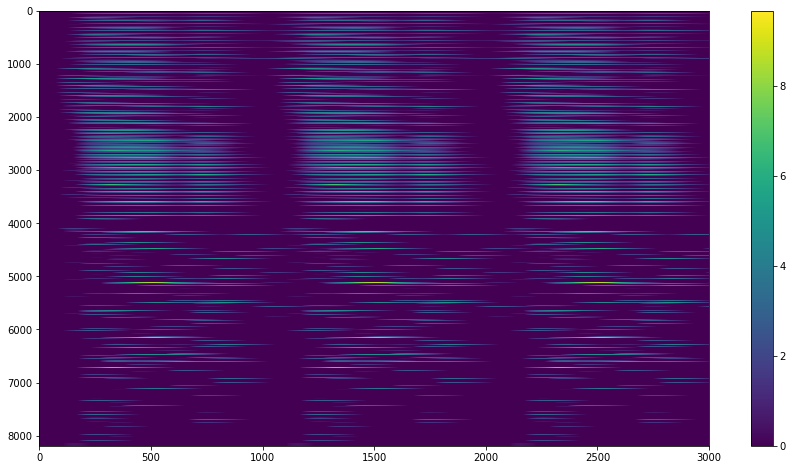

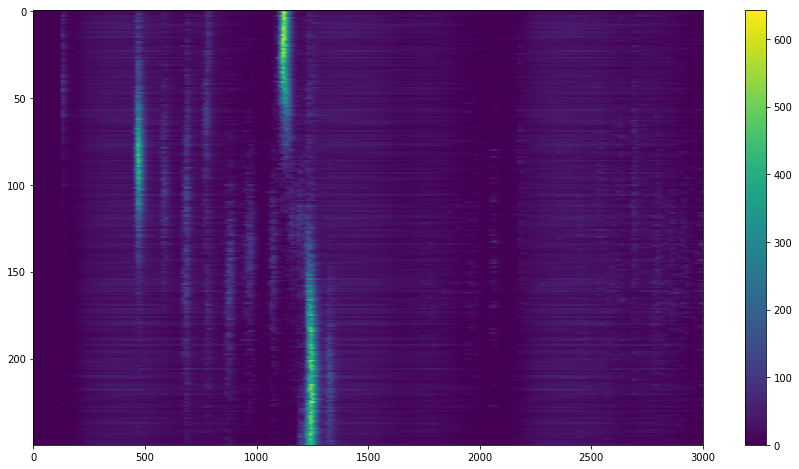

In [267]:
plt.figure(figsize=(15,8))
plt.imshow(exc_rates[:,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();

plt.figure(figsize=(15,8))
plt.imshow(inh_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();


0.3823965501444772


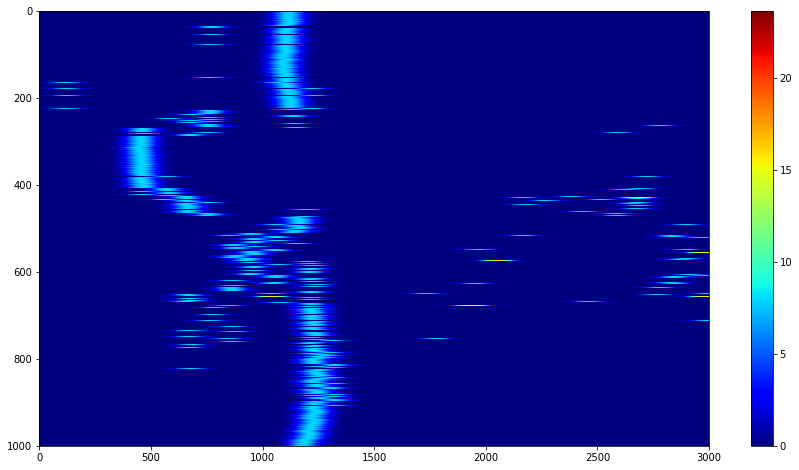

In [268]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
#output_rates = rates_isi(sim.trange(), output_spikes)
plt.figure(figsize=(15,8))
plt.imshow(output_rates.T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(output_rates))


0.3823965501444772


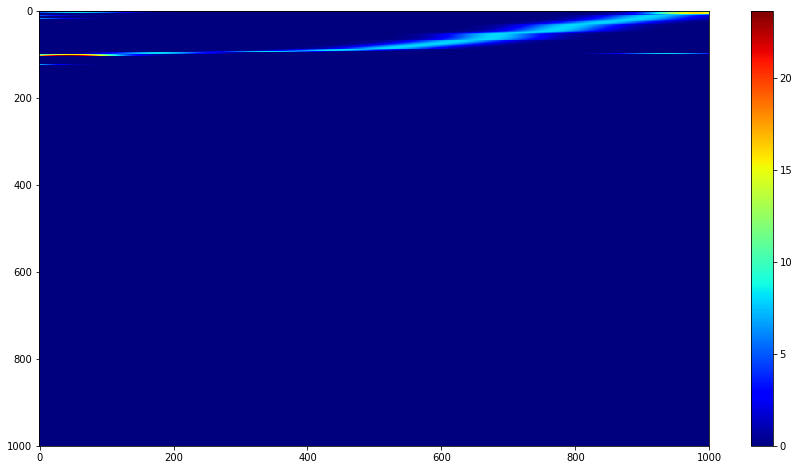

In [269]:
# output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates[2000:].T, axis=1))
plt.imshow(output_rates[2000:,sorted_idxs].T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(output_rates))
np.save("output_rates_dof.npy", output_rates)

0.3823965501444772


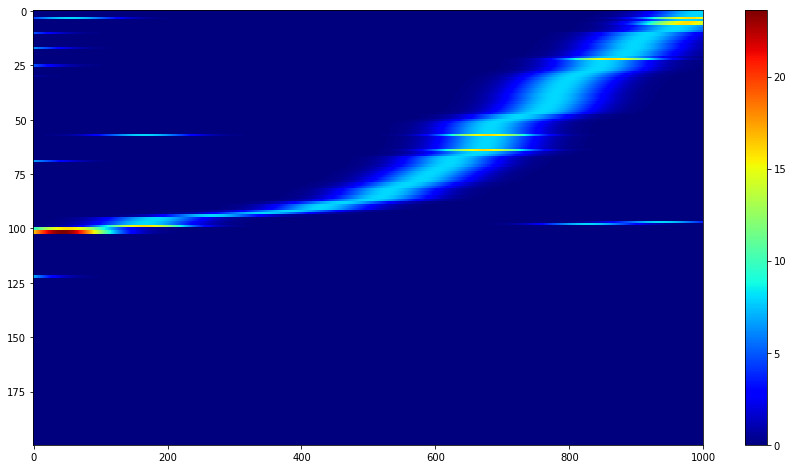

In [270]:
# output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates[2000:].T, axis=1))
plt.imshow(output_rates[2000:,sorted_idxs[:200]].T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(output_rates))
np.save("output_rates_dof.npy", output_rates)

0.3823965501444772


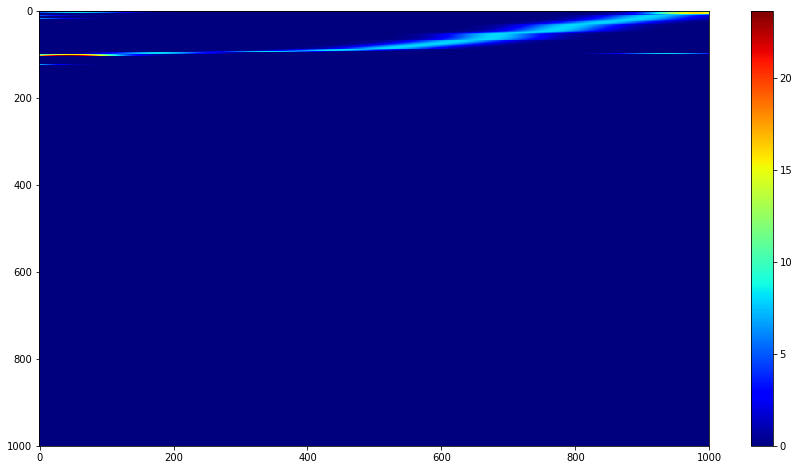

In [271]:
# output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates[2000:].T, axis=1))
plt.imshow(output_rates[2000:,sorted_idxs].T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(output_rates))


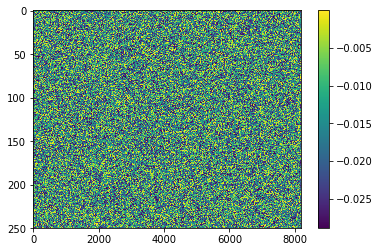

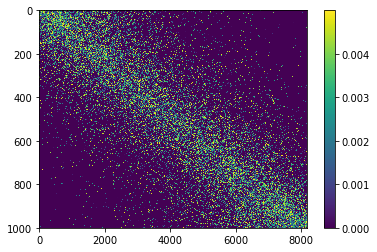

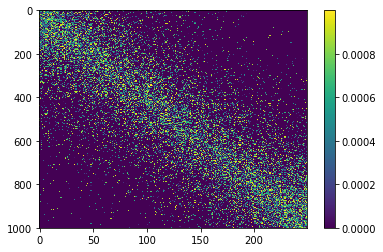

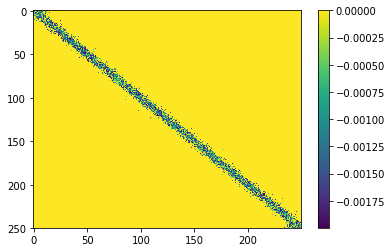

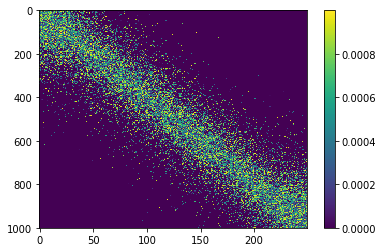

In [272]:
plt.figure();
plt.imshow(weights_initial_decoder_I.T, interpolation="nearest", aspect="auto");
plt.colorbar();
plt.figure();
plt.imshow(weights_initial_PV_E.T, interpolation="nearest", aspect="auto");
plt.colorbar();
plt.figure();
plt.imshow(weights_initial_PV_I.T, interpolation="nearest", aspect="auto");
plt.colorbar();
plt.figure();
plt.imshow(weights_initial_decoder_disinh.T, interpolation="nearest", aspect="auto");
plt.colorbar();
plt.figure();
plt.imshow(weights_initial_PV_disinh.T, interpolation="nearest", aspect="auto");
plt.colorbar();


(3, 8192, 250)
-0.6314166511866611


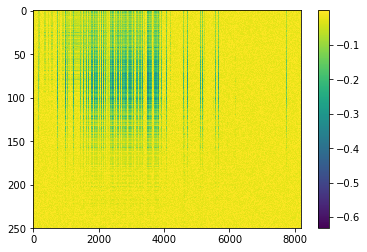

In [273]:
weights_decoder_I = sim.data[p_weights_decoder_I]
print(weights_decoder_I.shape)
plt.figure();
plt.imshow(weights_decoder_I[-1].T, interpolation="nearest", aspect="auto");
plt.colorbar();
print(np.min(weights_decoder_I[-1]))


0.3376821315824892
15.928993207824274


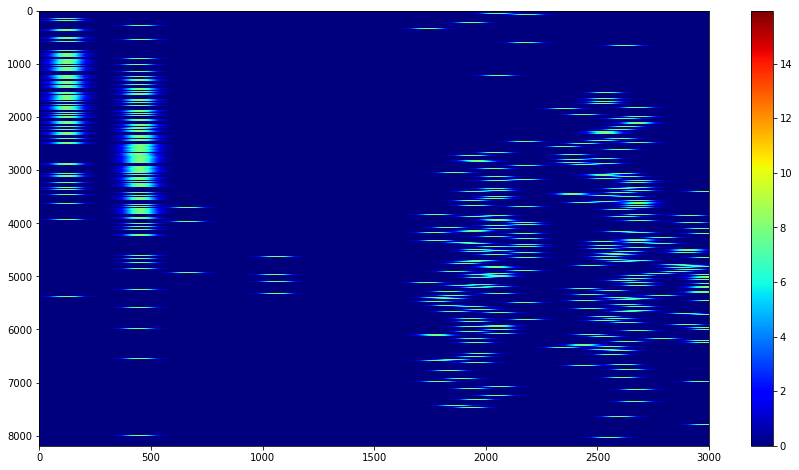

In [274]:

plt.figure(figsize=(15,8))
decoder_rates = rates_kernel(sim.trange(), decoder_spikes, tau=0.1)
plt.imshow(decoder_rates[:,:].T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(decoder_rates))
print(np.max(decoder_rates))


0.3376821315824892
15.928993207824274


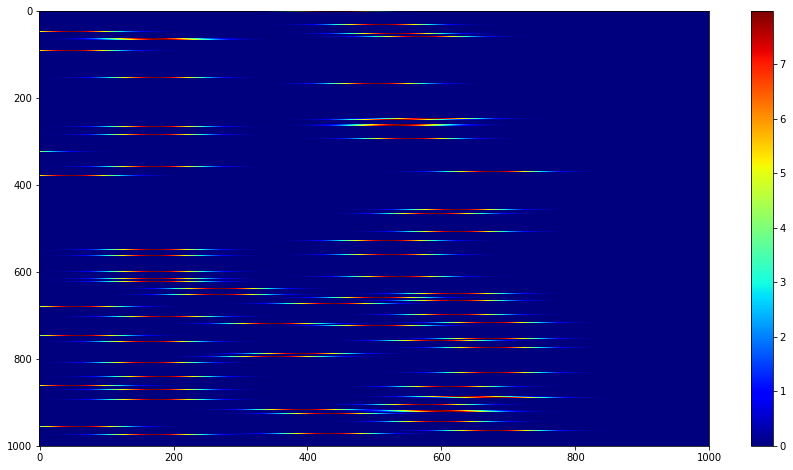

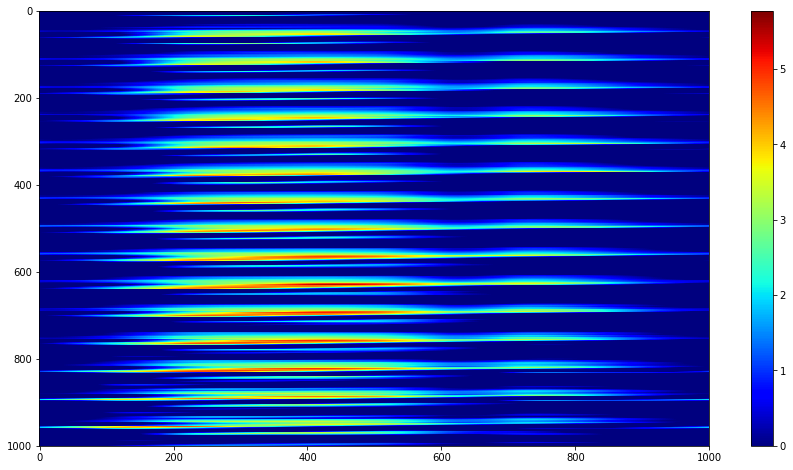

In [275]:

plt.figure(figsize=(15,8))
decoder_rates = rates_kernel(sim.trange(), decoder_spikes, tau=0.1)
plt.imshow(decoder_rates[2000:,:1000].T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(decoder_rates))
print(np.max(decoder_rates))

plt.figure(figsize=(15,8))
plt.imshow(exc_rates[2000:,:1000].T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();



3.3515468810041527


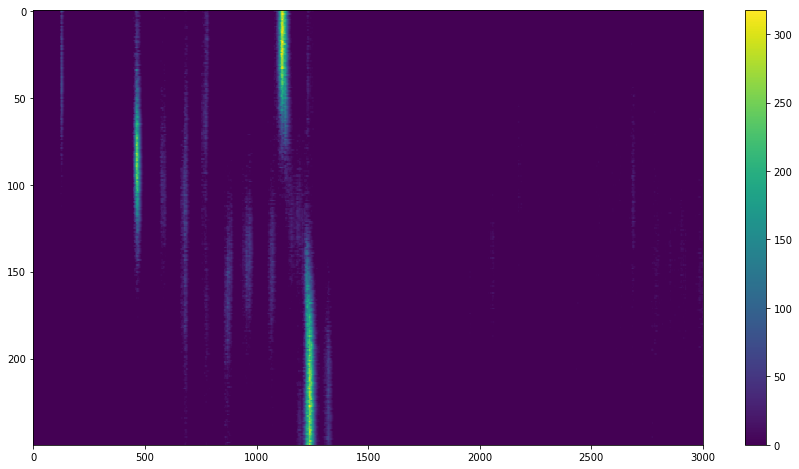

In [276]:

plt.figure(figsize=(15,8))
plt.imshow(decoder_inh_rates[:,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(decoder_inh_rates))


1.8139561917173321


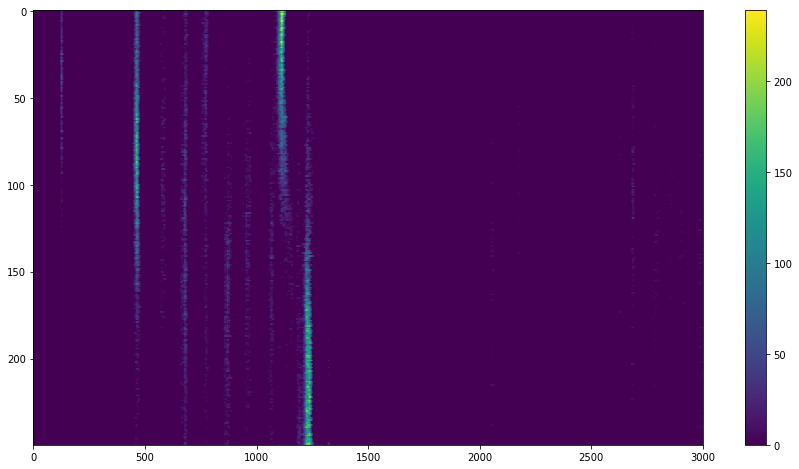

In [277]:

plt.figure(figsize=(15,8))
plt.imshow(decoder_npe_inh_rates[:,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(decoder_npe_inh_rates))


181.2692469220181


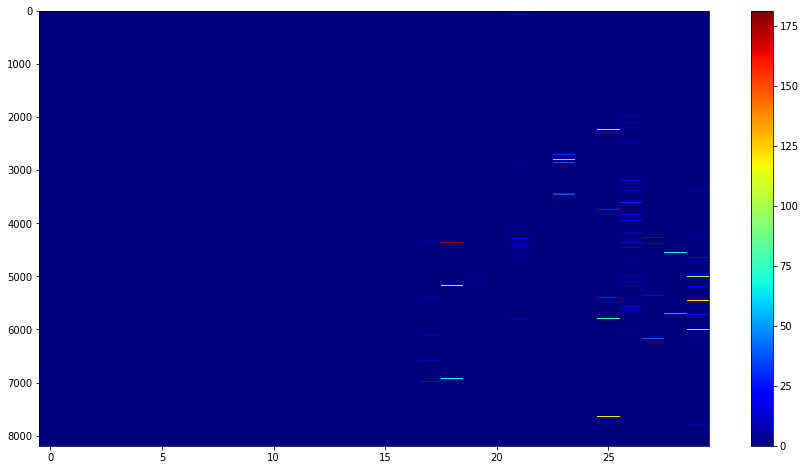

In [278]:
print(np.max(sim.data[p_cd]))
plt.figure(figsize=(15,8));
plt.imshow(sim.data[p_cd].T, interpolation="nearest", aspect="auto", cmap="jet");
plt.colorbar();


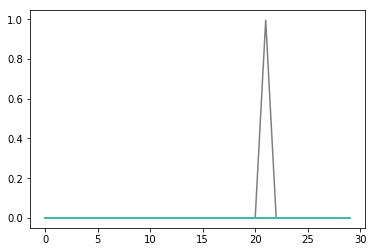

In [279]:
plt.plot(sim.data[p_cd][:,:10]);

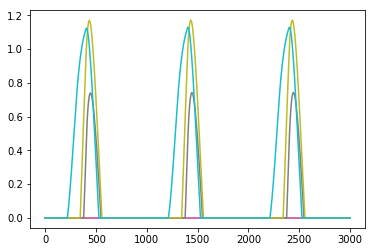

In [280]:
plt.plot(exc_rates[:,:10]);

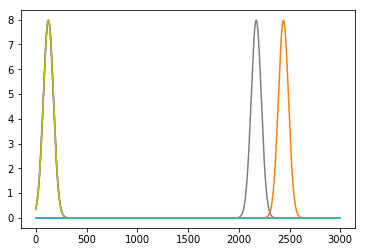

In [281]:
plt.plot(decoder_rates[:,:10]);